In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pip install scikit-plot

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [8]:
titanic_train = "/content/gdrive/MyDrive/Synapse-Task/synapse_w1/train.csv"
titanic_test = "/content/gdrive/MyDrive/Synapse-Task/synapse_w1/test.csv"
penguin_df = sns.load_dataset("penguins")
iris_df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv")
spam_df = pd.read_csv("/content/gdrive/MyDrive/DMW/datasets/spam.csv")
wine_df = pd.read_csv("/content/gdrive/MyDrive/DMW/datasets/WineQT.csv")

In [9]:
gaussian = []
decision = []

### Titanic

In [10]:
titanic_train_df = pd.read_csv(titanic_train)
titanic_test_df = pd.read_csv(titanic_test)

In [11]:
import re

titles = []
for nm in titanic_train_df.Name:
  title_search = re.search('(\w+)\.', nm)
  title = title_search.group(1)
  titles.append(title)

titanic_train_df['Title'] = titles

In [12]:
titanic_train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

In [13]:
titanic_train_df.drop(['PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)

In [14]:
nullPercent = {}
for i in titanic_train_df:
  null_count_i =  titanic_train_df.isnull().sum()[i]
  per = null_count_i*100/titanic_train_df.shape[0]
  nullPercent[i] = per


for i in nullPercent:
  # print(i)
  if(nullPercent[i] > 50) : titanic_train_df.drop([i], axis=1, inplace=True)

In [15]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [16]:

mean = np.mean(titanic_train_df.Age)
titanic_train_df['Age'].fillna(value=mean,  inplace=True)

In [17]:
train_df = titanic_train_df.assign(Family=lambda x: x.SibSp + x.Parch)

In [18]:
def zscore_norm(x):
 mean = np.mean(x)
 std = np.std(x)
 return (x-mean)/std

train_df = train_df.assign(Age=lambda x: zscore_norm(x.Age))
train_df = train_df.assign(Fare=lambda x: zscore_norm(x.Fare))
train_df = train_df.assign(Family=lambda x: zscore_norm(x.Family))

In [19]:
train_df = pd.get_dummies(train_df , columns=['Pclass', 'Sex', 'Title', 'Embarked'])
train_df

,Survived,Age,SibSp,Parch,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.592481,1,0,-0.502445,0.059160,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0.638789,1,0,0.786845,0.059160,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,1,-0.284663,0,0,-0.488854,-0.560975,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0.407926,1,0,0.420730,0.059160,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,0,0.407926,0,0,-0.486337,-0.560975,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,-0.207709,0,0,-0.386671,-0.560975,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
887,1,-0.823344,0,0,-0.044381,-0.560975,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
888,0,0.000000,1,2,-0.176263,1.299429,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
889,1,-0.284663,0,0,-0.044381,-0.560975,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [20]:
y = train_df.pop("Survived")
x = train_df

In [21]:
from sklearn.model_selection import train_test_split

In [22]:

x_train , x_valid , y_train , y_valid = train_test_split(x ,y, random_state=10, stratify=y, test_size=0.25 )
y_train.value_counts(normalize=True)

0    0.616766
1    0.383234
Name: Survived, dtype: float64

In [23]:
y_valid.value_counts(normalize=True)

0    0.61435
1    0.38565
Name: Survived, dtype: float64

In [24]:
# using naive bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_accuracy = nb_model.score(x_valid, y_valid)
print(nb_accuracy)

0.6278026905829597


In [25]:
# using decision tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_accuracy = dt_model.score(x_valid, y_valid)

In [30]:
gaussian.append(nb_accuracy)
decision.append(dt_accuracy)

[Text(0.5, 1.0, 'Titanic Dataset')]

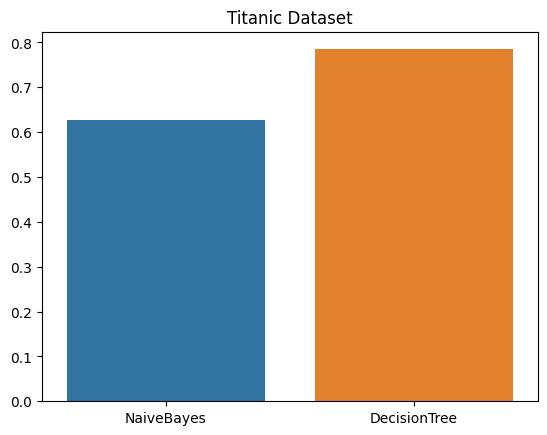

In [26]:
accuracy = [nb_accuracy, dt_accuracy]
Models = ['NaiveBayes','DecisionTree']
sns.barplot(x=Models,y=accuracy).set(title="Titanic Dataset")

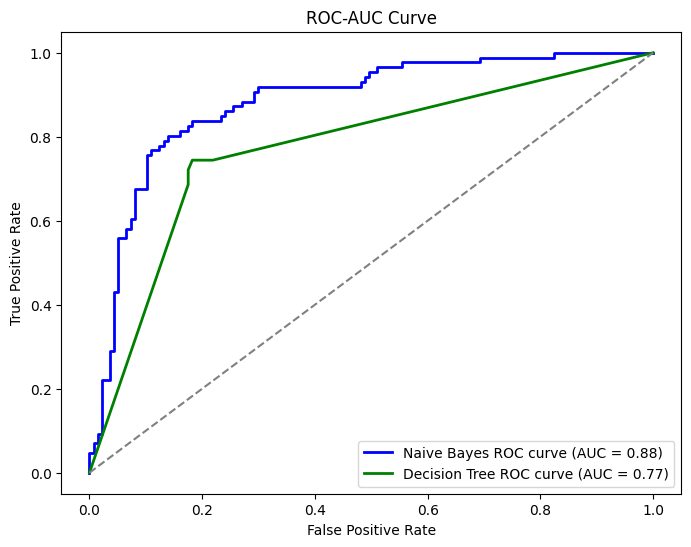

In [27]:
y_score_gnb = nb_model.predict_proba(x_valid)[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_valid, y_score_gnb)
roc_auc_gnb = roc_auc_score(y_valid, y_score_gnb)

y_score_dtc = dt_model.predict_proba(x_valid)[:, 1]
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_valid, y_score_dtc)
roc_auc_dtc = roc_auc_score(y_valid, y_score_dtc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label='Naive Bayes ROC curve (AUC = {:.2f})'.format(roc_auc_gnb))
plt.plot(fpr_dtc, tpr_dtc, color='green', lw=2, label='Decision Tree ROC curve (AUC = {:.2f})'.format(roc_auc_dtc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

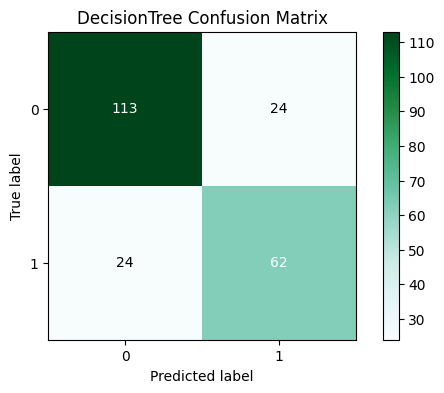

In [28]:
q = y_valid

pred_test = dt_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='DecisionTree Confusion Matrix', cmap='BuGn')

y_valid = q

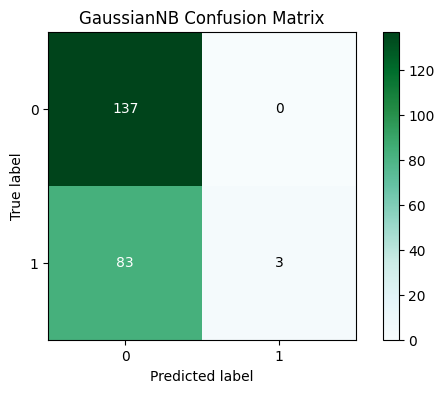

In [29]:
q = y_valid

pred_test = nb_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='GaussianNB Confusion Matrix', cmap='BuGn')

y_test = q

In [32]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=7,shuffle=True,random_state=10)
cv_score = cross_val_score(estimator=nb_model,X=x_train,y=y_train,cv=kf,scoring='accuracy')
mean_cv_score = np.mean(cv_score)
print(mean_cv_score)

0.6526472431077694


In [33]:
# ensemble tech - RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_accuracy = rf_model.score(x_valid, y_valid)
print(rf_accuracy)

0.8295964125560538


Text(0.5, 1.0, 'Accuracy of Different Models')

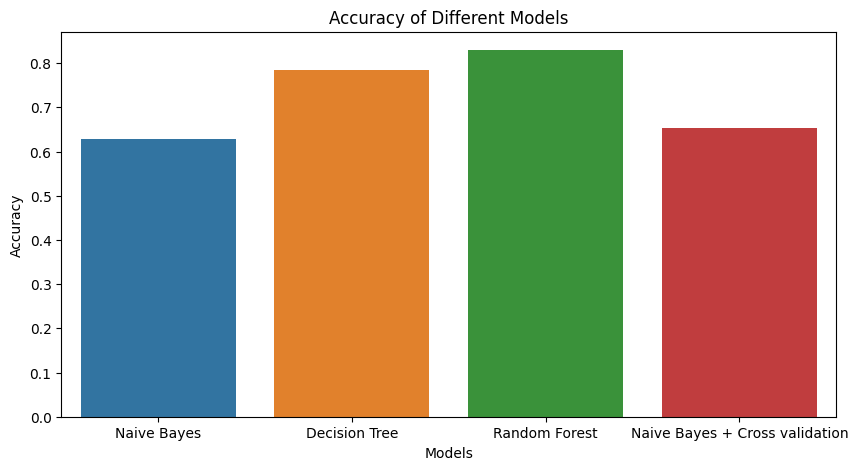

In [41]:
accuracies=[nb_accuracy,dt_accuracy,rf_accuracy,mean_cv_score]
plt.figure(figsize=(10,5))
models=['Naive Bayes','Decision Tree','Random Forest','Naive Bayes + Cross validation']
sns.barplot(x=models,y=accuracies,).set(title='Part C')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')

### Penguin

In [42]:
pg_df = penguin_df
pg_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [43]:
pg_df.shape

(344, 7)

In [44]:
pg_df.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [45]:
pg_df.island.unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [46]:
pg_df.dropna(inplace=True)

In [47]:
pg_df = pd.get_dummies(pg_df, columns=['island','sex'])

In [48]:
y = pg_df.pop('species')
X = pg_df

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(X,y,random_state=10,stratify=y, test_size=0.25)
y_train.value_counts(normalize=True)

Adelie       0.437751
Gentoo       0.357430
Chinstrap    0.204819
Name: species, dtype: float64

In [50]:
y_valid.value_counts(normalize=True)

Adelie       0.440476
Gentoo       0.357143
Chinstrap    0.202381
Name: species, dtype: float64

In [51]:
# using naive bayes
from sklearn.naive_bayes import GaussianNB
nb_model = OneVsRestClassifier(GaussianNB())
nb_model.fit(x_train, y_train)
nb_accuracy = nb_model.score(x_valid, y_valid)
print(nb_accuracy)

0.9166666666666666


In [52]:
# using decision tree
from sklearn.tree import DecisionTreeClassifier
dt_model = OneVsRestClassifier(DecisionTreeClassifier())
dt_model.fit(x_train, y_train)
dt_accuracy = dt_model.score(x_valid, y_valid)
print(dt_accuracy)

0.9761904761904762


In [53]:
gaussian.append(nb_accuracy)
decision.append(dt_accuracy)

[Text(0.5, 1.0, 'Penguin Dataset')]

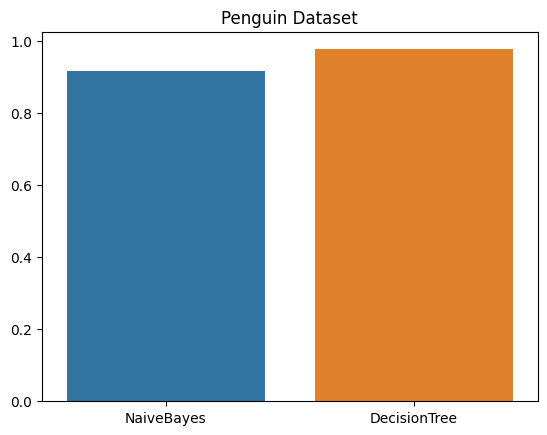

In [54]:
accuracy = [nb_accuracy, dt_accuracy]
Models = ['NaiveBayes','DecisionTree']
sns.barplot(x=Models,y=accuracy).set(title="Penguin Dataset")

In [55]:
y_score_gnb = nb_model.predict_proba(x_valid)
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_valid.values, y_score_gnb.values)
roc_auc_gnb = roc_auc_score(y_valid, y_score_gnb)

y_score_dtc = dt_model.predict_proba(x_valid)
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_valid.values, y_score_dtc.values)
roc_auc_dtc = roc_auc_score(y_valid, y_score_dtc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label='Naive Bayes ROC curve (AUC = {:.2f})'.format(roc_auc_gnb))
plt.plot(fpr_dtc, tpr_dtc, color='green', lw=2, label='Decision Tree ROC curve (AUC = {:.2f})'.format(roc_auc_dtc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

AttributeError: ignored

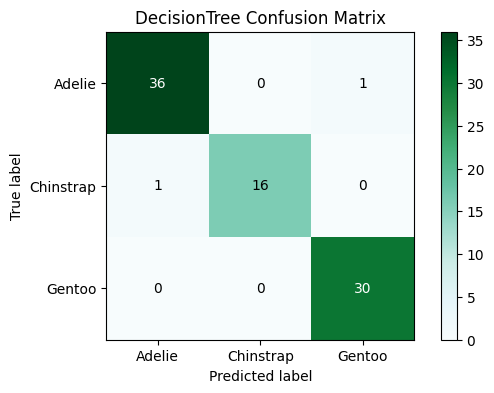

In [56]:
q = y_valid

pred_test = dt_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='DecisionTree Confusion Matrix', cmap='BuGn')

y_test = q

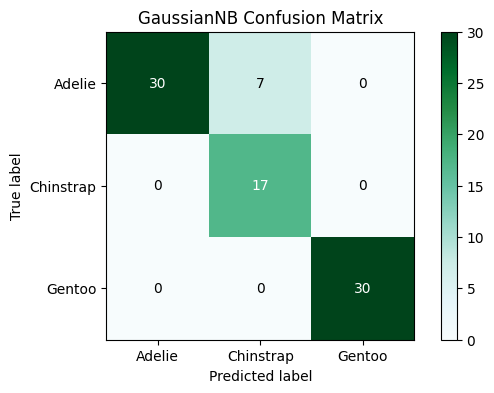

In [57]:
q = y_valid

pred_test = nb_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='GaussianNB Confusion Matrix', cmap='BuGn')

y_test = q

In [58]:
y_score_gnb = nb_model.predict_proba(x_valid)
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_valid.values, y_score_gnb.values)
roc_auc_gnb = roc_auc_score(y_valid, y_score_gnb)

y_score_dtc = dt_model.predict_proba(x_valid)
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_valid.values, y_score_dtc.values)
roc_auc_dtc = roc_auc_score(y_valid, y_score_dtc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label='Naive Bayes ROC curve (AUC = {:.2f})'.format(roc_auc_gnb))
plt.plot(fpr_dtc, tpr_dtc, color='green', lw=2, label='Decision Tree ROC curve (AUC = {:.2f})'.format(roc_auc_dtc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

AttributeError: ignored

### Iris

In [59]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [60]:
iris_df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [61]:
y = iris_df.pop('species')
X = iris_df

In [62]:
x_train, x_valid, y_train, y_valid = train_test_split(X,y,random_state=10,stratify=y, test_size=0.25)
y_train.value_counts(normalize=True)

setosa        0.339286
virginica     0.330357
versicolor    0.330357
Name: species, dtype: float64

In [63]:
# using naive bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_accuracy = nb_model.score(x_valid, y_valid)
print(nb_accuracy)

1.0


In [64]:
# using decision tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_accuracy = dt_model.score(x_valid, y_valid)
print(dt_accuracy)

0.9736842105263158


In [65]:
gaussian.append(nb_accuracy)
decision.append(dt_accuracy)

[Text(0.5, 1.0, 'Iris Dataset')]

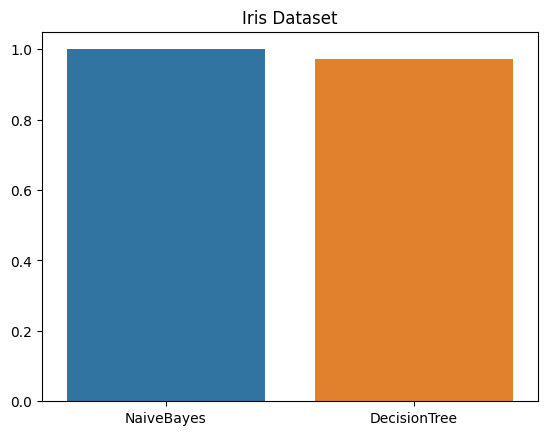

In [66]:
accuracy = [nb_accuracy, dt_accuracy]
Models = ['NaiveBayes','DecisionTree']
sns.barplot(x=Models,y=accuracy).set(title="Iris Dataset")

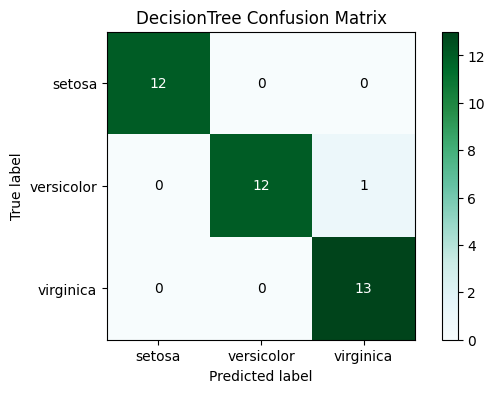

In [67]:
q = y_valid

pred_test = dt_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='DecisionTree Confusion Matrix', cmap='BuGn')

y_test = q

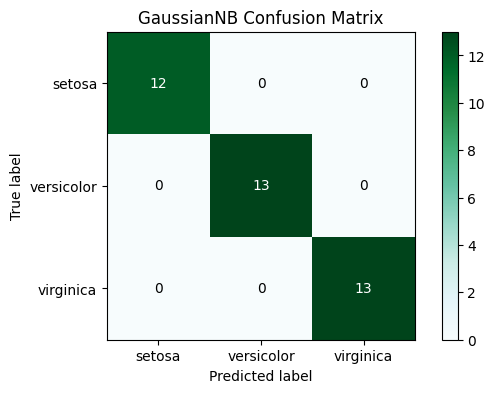

In [68]:
q = y_valid

pred_test = nb_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='GaussianNB Confusion Matrix', cmap='BuGn')

y_test = q

### spam

In [69]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [70]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [71]:
spam_df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [72]:
def cleaning (text):
    # text = text.lower()
    text =  re.sub(r'@\S+', '',text)
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

In [73]:
spam_df["Message"]=spam_df["Message"].apply(cleaning)

In [74]:
def lemmatize(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Message'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    data=data.drop("Message",axis=1)
    return data

In [75]:
spam_df = lemmatize(spam_df)

In [76]:
obj = {"ham":0,"spam":1}
spam_df["Category"]=spam_df["Category"].map(obj)

In [77]:
X = spam_df['text']
y = spam_df['Category']

In [78]:
x_train, x_valid, y_train, y_valid = train_test_split(X,y,random_state=10,stratify=y, test_size=0.25)
y_train.value_counts(normalize=True)

0    0.865997
1    0.134003
Name: Category, dtype: float64

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
x_train.shape

(4179,)

In [81]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(x_train)
x_valid = tfidf.transform(x_valid)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

pred = dt_model.predict(x_valid)
dt_accuracy = accuracy_score(pred, y_valid)
print(dt_accuracy)

0.9569274946159368


In [82]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)

pred = nb_model.predict(x_valid.toarray())
nb_accuracy = accuracy_score(pred, y_valid)
print(nb_accuracy)

0.8793969849246231


In [83]:
gaussian.append(nb_accuracy)
decision.append(dt_accuracy)

[Text(0.5, 1.0, 'Spam Text Message classification')]

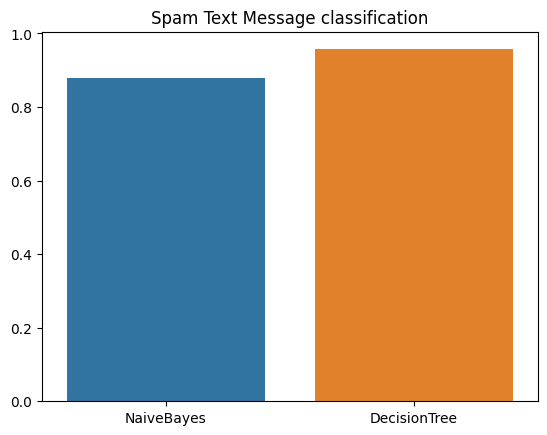

In [84]:
accuracy = [nb_accuracy, dt_accuracy]
Models = ['NaiveBayes','DecisionTree']
sns.barplot(x=Models,y=accuracy).set(title="Spam Text Message classification")

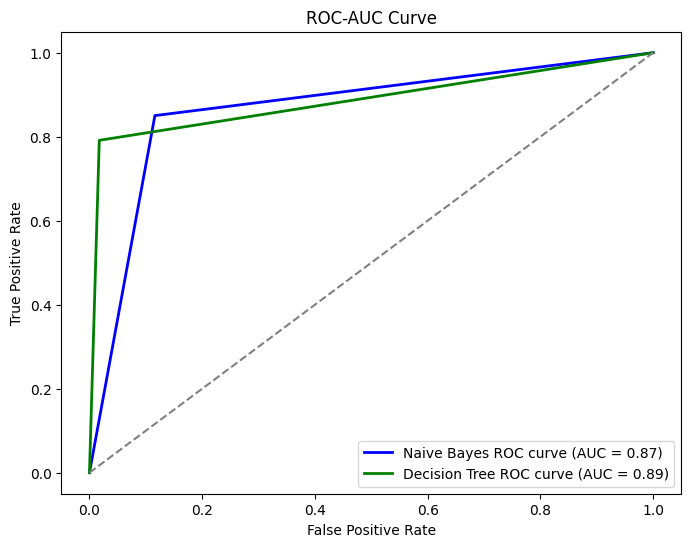

In [85]:
y_score_gnb = nb_model.predict_proba(x_valid.toarray())[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_valid, y_score_gnb)
roc_auc_gnb = roc_auc_score(y_valid, y_score_gnb)

y_score_dtc = dt_model.predict_proba(x_valid)[:, 1]
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_valid, y_score_dtc)
roc_auc_dtc = roc_auc_score(y_valid, y_score_dtc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label='Naive Bayes ROC curve (AUC = {:.2f})'.format(roc_auc_gnb))
plt.plot(fpr_dtc, tpr_dtc, color='green', lw=2, label='Decision Tree ROC curve (AUC = {:.2f})'.format(roc_auc_dtc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

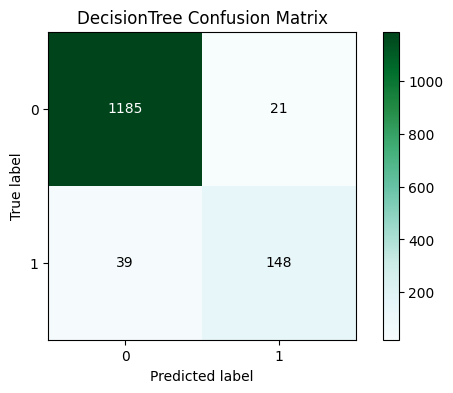

In [86]:
q = y_valid

pred_test = dt_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='DecisionTree Confusion Matrix', cmap='BuGn')

y_valid = q

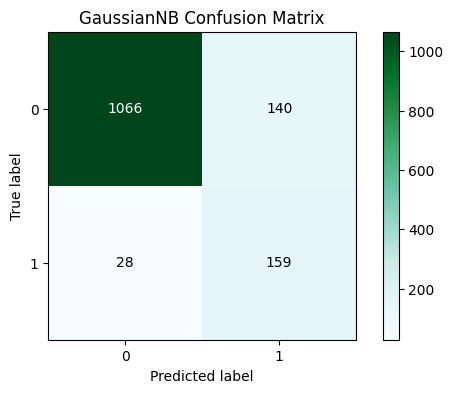

In [87]:
q = y_valid

pred_test = nb_model.predict(x_valid.toarray())
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='GaussianNB Confusion Matrix', cmap='BuGn')

y_valid = q

### wine dataset

In [88]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [89]:
y = wine_df.pop('quality')
X = wine_df

In [90]:
x_train, x_valid, y_train, y_valid = train_test_split(X,y,random_state=10,stratify=y, test_size=0.25)
y_train.value_counts(normalize=True)

5    0.422404
6    0.403734
7    0.124854
4    0.029172
8    0.014002
3    0.005834
Name: quality, dtype: float64

In [91]:
# using naive bayes
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_accuracy = nb_model.score(x_valid, y_valid)
print(nb_accuracy)

0.5699300699300699


In [92]:
# using decision tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_accuracy = dt_model.score(x_valid, y_valid)
print(dt_accuracy)

0.6678321678321678


In [93]:
gaussian.append(nb_accuracy)
decision.append(dt_accuracy)

[Text(0.5, 1.0, 'Wine Quality Classifier')]

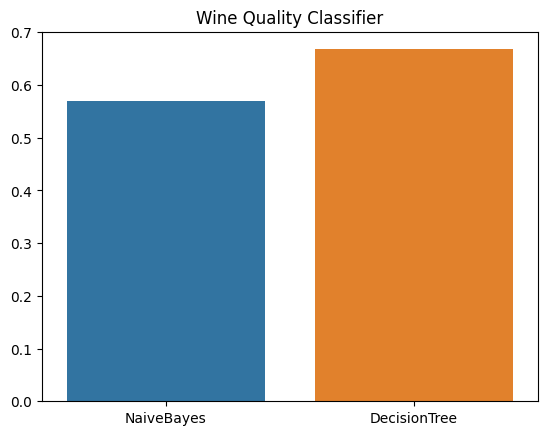

In [94]:
accuracy = [nb_accuracy, dt_accuracy]
Models = ['NaiveBayes','DecisionTree']
sns.barplot(x=Models,y=accuracy).set(title="Wine Quality Classifier")

In [95]:
y_score_gnb = nb_model.predict_proba(x_valid)
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_valid.values, y_score_gnb.values)
roc_auc_gnb = roc_auc_score(y_valid, y_score_gnb)

y_score_dtc = dt_model.predict_proba(x_valid)
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_valid.values, y_score_dtc.values)
roc_auc_dtc = roc_auc_score(y_valid, y_score_dtc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, label='Naive Bayes ROC curve (AUC = {:.2f})'.format(roc_auc_gnb))
plt.plot(fpr_dtc, tpr_dtc, color='green', lw=2, label='Decision Tree ROC curve (AUC = {:.2f})'.format(roc_auc_dtc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

AttributeError: ignored

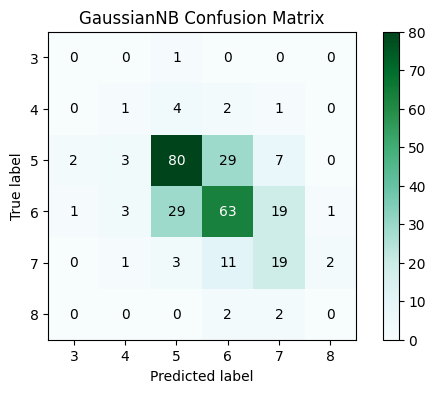

In [96]:
q = y_valid

pred_test = nb_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='GaussianNB Confusion Matrix', cmap='BuGn')

y_test = q

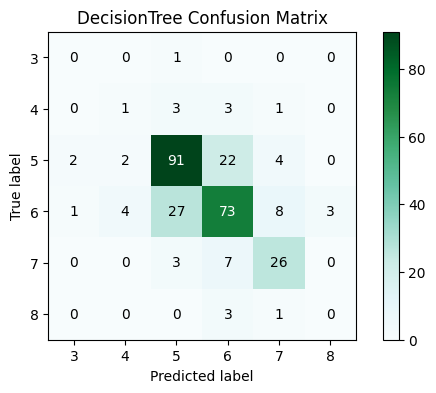

In [97]:
q = y_valid

pred_test = dt_model.predict(x_valid)
pred_test = pd.DataFrame(pred_test)
y_valid = pd.DataFrame(y_valid)

plot_confusion_matrix(y_valid, pred_test, figsize=(7,4), title='DecisionTree Confusion Matrix', cmap='BuGn')

y_test = q

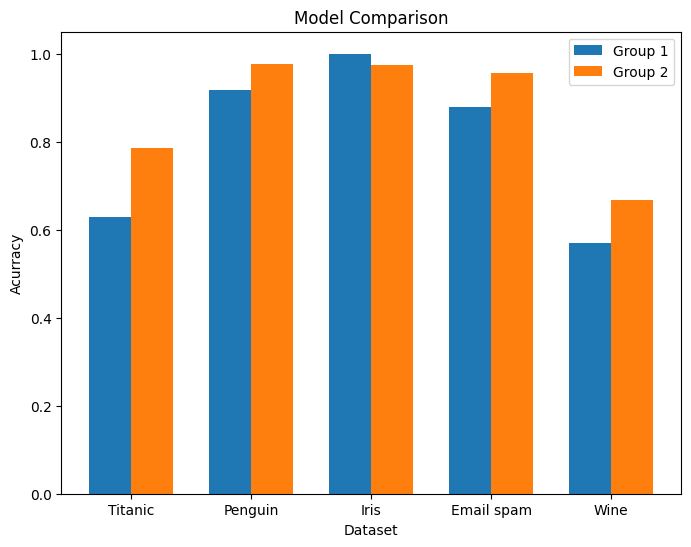

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def grouped_barplot(data1, data2, labels, xticklabels=None, title="Grouped Barplot"):
    """
    Generate a grouped barplot using Seaborn.

    Parameters:
    - data1: List or array of values for the first group.
    - data2: List or array of values for the second group.
    - labels: List of labels for each bar.
    - xticklabels: List of labels for x-axis ticks (optional).
    - title: Title of the plot (optional).

    Returns:
    - None (displays the plot).
    """

    # Set the positions and width for the bars
    positions = np.arange(len(labels))
    width = 0.35  # Width of the bars

    # Create the grouped barplot
    plt.figure(figsize=(8, 6))
    plt.bar(positions - width/2, data1, width, label='Group 1')
    plt.bar(positions + width/2, data2, width, label='Group 2')

    # Set labels and title
    plt.xlabel('Dataset')
    plt.ylabel('Acurracy')
    plt.title(title)

    # Set x-axis ticks and labels
    plt.xticks(positions, labels)
    if xticklabels:
        plt.xticks(positions, xticklabels)

    # Display legend
    plt.legend()

    # Show the plot
    plt.show()

category_labels = ['Titanic', 'Penguin', 'Iris', 'Email spam', 'Wine']

grouped_barplot(gaussian, decision, category_labels, title="Model Comparison")
